In [1]:
import os 
import glob
imdb_dir = '/Users/halahalsaadi/Downloads/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [2]:
# Import various modules for string cleaning
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords

def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [3]:
import re


def clean_text(text): 
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text) 
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
maxlen = 100 
training_samples = 1500
validation_samples = 500
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 88582 unique tokens.


In [5]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples] 
y_val = labels[training_samples: training_samples + validation_samples]

In [7]:
glove_dir = '/Users/halahalsaadi/Downloads/glove'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


In [9]:
maxlen = 100 
training_samples = 1500
validation_samples = 500
max_words = 10000
epochs = 15
batch_size = 64

In [10]:
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from keras.layers import LSTM

In [67]:
model = Sequential()
model.add(Embedding(max_words, 100))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.5)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.5)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.5)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation = 'sigmoid'))

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, None, 64)          34048     
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
bidirectional_7 (Bidirection (None, None, 64)          24832     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 1,108,609
Trainable params: 1,108,609
Non-trainable params: 0
_________________________________________________________________


In [69]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [70]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=15,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model9.h5')

Train on 1500 samples, validate on 500 samples
Epoch 1/15
1500/1500 [==============================] - 26s 18ms/step - loss: 0.6910 - acc: 0.5367 - val_loss: 0.6877 - val_acc: 0.5220
Epoch 2/15
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6905 - acc: 0.5253 - val_loss: 0.6778 - val_acc: 0.6340
Epoch 3/15
1500/1500 [==============================] - 17s 11ms/step - loss: 0.6793 - acc: 0.5747 - val_loss: 0.6545 - val_acc: 0.6540
Epoch 4/15
1500/1500 [==============================] - 17s 11ms/step - loss: 0.6647 - acc: 0.6040 - val_loss: 0.6270 - val_acc: 0.6660
Epoch 5/15
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6375 - acc: 0.6387 - val_loss: 0.6096 - val_acc: 0.6620
Epoch 6/15
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6285 - acc: 0.6493 - val_loss: 0.6103 - val_acc: 0.6800
Epoch 7/15
1500/1500 [==============================] - 18s 12ms/step - loss: 0.6105 - acc: 0.6660 - val_loss: 0.5599 - val_acc: 0.7180
E

In [71]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

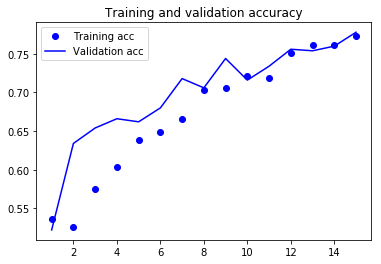

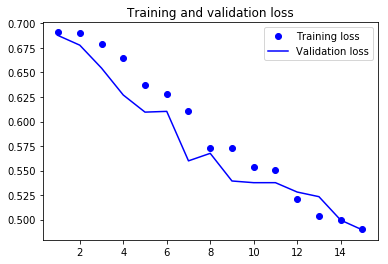

In [72]:
#plotting the model result:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [73]:
import numpy as np
k=4
num_val_samples = len(x_train) // k 
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate( [x_train[:i * num_val_samples],
                                          x_train[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [y_train[:i * num_val_samples],
                                             y_train[(i + 1) * num_val_samples:]], axis=0)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [83]:
def build_model():
    model = Sequential()
    model.add(Embedding(max_words, 100))
    model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.5, input_shape=(data.shape[1]))))
    model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.5)))
    model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.5)))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1, activation = 'sigmoid'))
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model

In [89]:
model.fit(partial_train_data, partial_train_targets,
          epochs=15, batch_size=64, verbose=0)





In [90]:
val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
all_scores.append(val_mae)


In [91]:
all_scores

[0.7759999984105428]

In [92]:
np.mean(all_scores)

0.7759999984105428

In [96]:
history = model.fit(partial_train_data, partial_train_targets,
                    validation_data=(val_data, val_targets),epochs=15, batch_size=64, verbose=0)


In [102]:
num_epochs = 15 
all_mae_histories = [] 
for i in range(k):
    print('processing fold #', i)
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate( [x_train[:i * num_val_samples],
                                      x_train[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [y_train[:i * num_val_samples],
                                             y_train[(i + 1) * num_val_samples:]], axis=0)

 


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [110]:
mae_history = history.history
all_mae_histories.append(mae_history)

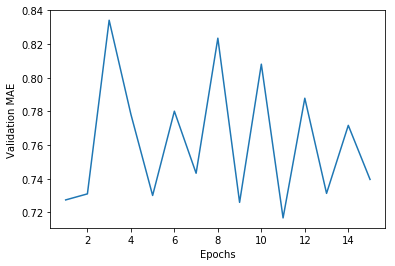

In [113]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


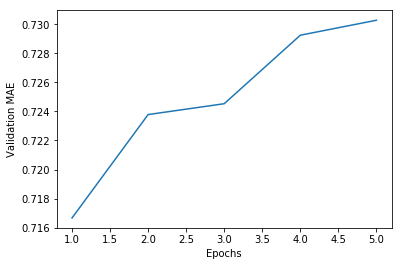

In [114]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()


In [115]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
        
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)


In [116]:
model.load_weights('pre_trained_glove_model9.h5')
score, acc = model.evaluate(x_test, y_test)

25000/25000 [==============================] - 75s 3ms/step


In [117]:
print('Test Score:', score)
print('Test Accuracy:', acc)

Test Score: 0.5167837489271164
Test Accuracy: 0.75012


In [118]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [119]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [122]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)


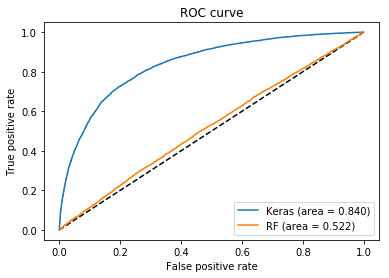

In [123]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

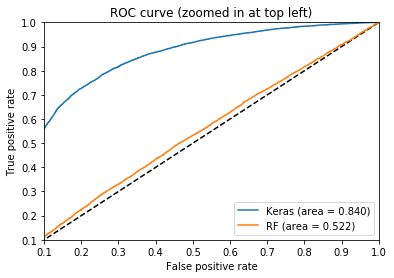

In [124]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0.1, 1.0)
plt.ylim(0.1, 1.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [125]:
print(auc_keras)

0.8400607520000001


In [126]:
print(auc_rf)

0.5217286463999999


In [127]:
print(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [128]:
print(fpr_rf)

[0.000e+00 1.600e-04 1.600e-04 ... 9.996e-01 9.996e-01 1.000e+00]


In [129]:
print(tpr_rf)

[8.0000e-05 8.0000e-05 1.6000e-04 ... 9.9992e-01 1.0000e+00 1.0000e+00]


In [130]:
print(y_pred_rf)

[0.50200717 0.52873353 0.51780288 ... 0.51835848 0.52257632 0.54471867]


In [131]:
print(roc_curve)

<function roc_curve at 0x1151ccea0>


In [132]:
print(y_pred_keras)

[0.44338322 0.2676679  0.08719934 ... 0.39382878 0.91273344 0.90959764]


In [133]:
print(thresholds_keras)

[0.975112   0.9727395  0.97270423 ... 0.04317759 0.04304634 0.02914783]


In [134]:
print(fpr_rf)

[0.000e+00 1.600e-04 1.600e-04 ... 9.996e-01 9.996e-01 1.000e+00]
